In [1]:
from utils import read_csv_data, clean_location, build_column_vocabulary, convert_to_one_hot, cat_emb

In [2]:
# Change to Categorical
data = read_csv_data("../data/processed_job_postings_large_noNA.csv", 
                     ["industry", "work_type", "location", "formatted_experience_level", "title_emb"], "salary_level")
data = clean_location(data, 2)

import random
random.seed(70)
random.shuffle(data)

train_data = data[:10000]
val_data = data[10000:13000]
test_data = data[13000:]

In [3]:
vocab_sector = build_column_vocabulary(train_data, 0)
vocab_type = build_column_vocabulary(train_data, 1)
vocab_state = build_column_vocabulary(train_data, 2)
vocab_level = build_column_vocabulary(train_data, 3)
len(vocab_type)

7

In [4]:
import torch
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

targets = [data[i][1] for i in range(len(data))]

labels = ['10K-'] + [f"{i}K - {i + 10}K" for i in range(10, 150, 10)] + ['160K+']
label_to_int = {label: i for i, label in enumerate(labels)}

targets = list(map(lambda x: label_to_int[x], targets))

targets = torch.tensor(targets)

train_targets = targets[:10000]
val_targets = targets[10000:13000]
test_targets = targets[13000:]

In [6]:
# Attempt with basic MLP

from mlp import MLPDataset
# temp looks like this
# [[Tensor1, Tensor2, Tensor3, Tensor4], ...]
temp = convert_to_one_hot(train_data, 
                          [(0, vocab_sector),
                           (1, vocab_type),
                           (2, vocab_state),
                           (3, vocab_level)])
train_one_hot = MLPDataset(temp, [target.type(torch.LongTensor) for target in train_targets])



temp = convert_to_one_hot(val_data, 
                          [(0, vocab_sector),
                           (1, vocab_type),
                           (2, vocab_state),
                           (3, vocab_level)])
val_one_hot = MLPDataset(temp, [target.type(torch.LongTensor) for target in val_targets])

In [7]:
from mlp import MLP, train_classifier
total_features = train_one_hot[0][0].shape[0]
model = MLP(input_size=total_features, hidden_size=1000, output_size=len(labels))  

Iter 50: Loss: 2.6089935302734375 Train Acc: 0.1443, Validation Acc: 0.15166666666666667
Iter 100: Loss: 2.5273630619049072 Train Acc: 0.1734, Validation Acc: 0.18166666666666667
Iter 150: Loss: 2.5535619258880615 Train Acc: 0.2067, Validation Acc: 0.212
Iter 200: Loss: 2.4389495849609375 Train Acc: 0.2138, Validation Acc: 0.21733333333333332
Iter 250: Loss: 2.4314606189727783 Train Acc: 0.2099, Validation Acc: 0.211
Iter 300: Loss: 2.465698719024658 Train Acc: 0.2213, Validation Acc: 0.22733333333333333
Iter 350: Loss: 2.4337000846862793 Train Acc: 0.2268, Validation Acc: 0.22866666666666666
Iter 400: Loss: 2.3893167972564697 Train Acc: 0.2386, Validation Acc: 0.23733333333333334
Iter 450: Loss: 2.2164695262908936 Train Acc: 0.2298, Validation Acc: 0.23266666666666666
Iter 500: Loss: 2.2449872493743896 Train Acc: 0.2356, Validation Acc: 0.235
Iter 550: Loss: 2.3669090270996094 Train Acc: 0.2413, Validation Acc: 0.238
Iter 600: Loss: 2.1830403804779053 Train Acc: 0.2464, Validation Acc

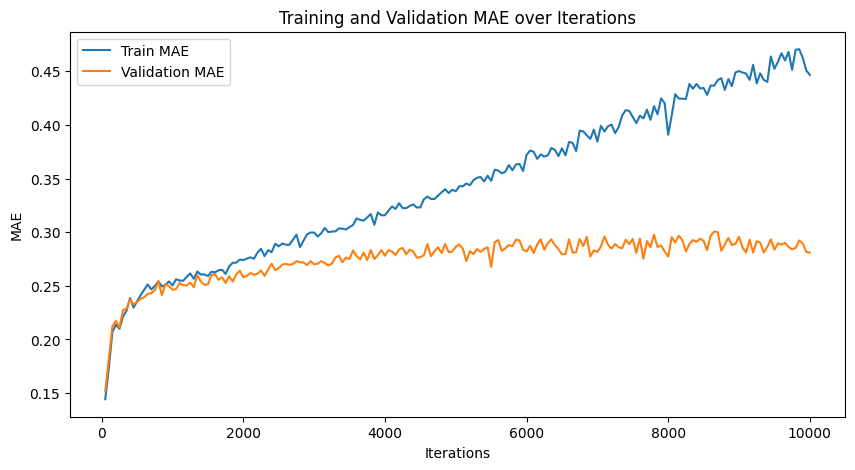

In [8]:
train_classifier(model, train_one_hot, val_one_hot, 0.1, batch_size=100, num_epochs=100)

In [5]:
# Attempt to add topic embedding to improve the model

from mlp import MLPDataset
# temp looks like this
# [[Tensor1, Tensor2, Tensor3, Tensor4], ...]
temp = convert_to_one_hot(train_data, 
                          [(0, vocab_sector),
                           (1, vocab_type),
                           (2, vocab_state),
                           (3, vocab_level)])
temp = cat_emb(temp, train_data, 4)
train_one_hot_with_emb = MLPDataset(temp, [target.type(torch.LongTensor) for target in train_targets])

temp = convert_to_one_hot(val_data, 
                          [(0, vocab_sector),
                           (1, vocab_type),
                           (2, vocab_state),
                           (3, vocab_level)])
temp = cat_emb(temp, val_data, 4)
print(temp[0].shape)
val_one_hot_with_emb = MLPDataset(temp, [target.type(torch.LongTensor) for target in val_targets])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

IndexError: list index out of range

In [10]:
from mlp import MLP, train_classifier
total_features = train_one_hot_with_emb[0][0].shape[0]
model2 = MLP(input_size=total_features, hidden_size=1000, output_size=len(labels))  

Iter 50: Loss: 2.6372931003570557 Train Acc: 0.1443, Validation Acc: 0.15166666666666667
Iter 100: Loss: 2.627774715423584 Train Acc: 0.1443, Validation Acc: 0.15166666666666667
Iter 150: Loss: 2.56620717048645 Train Acc: 0.155, Validation Acc: 0.162
Iter 200: Loss: 2.637505531311035 Train Acc: 0.2162, Validation Acc: 0.22066666666666668
Iter 250: Loss: 2.52982759475708 Train Acc: 0.2265, Validation Acc: 0.22866666666666666
Iter 300: Loss: 2.3854641914367676 Train Acc: 0.2254, Validation Acc: 0.22933333333333333
Iter 350: Loss: 2.2746713161468506 Train Acc: 0.2385, Validation Acc: 0.241
Iter 400: Loss: 2.336242437362671 Train Acc: 0.2438, Validation Acc: 0.24266666666666667
Iter 450: Loss: 2.4860804080963135 Train Acc: 0.2605, Validation Acc: 0.264
Iter 500: Loss: 2.181154251098633 Train Acc: 0.2535, Validation Acc: 0.25466666666666665
Iter 550: Loss: 2.0540425777435303 Train Acc: 0.2697, Validation Acc: 0.2683333333333333
Iter 600: Loss: 2.0642147064208984 Train Acc: 0.273, Validation

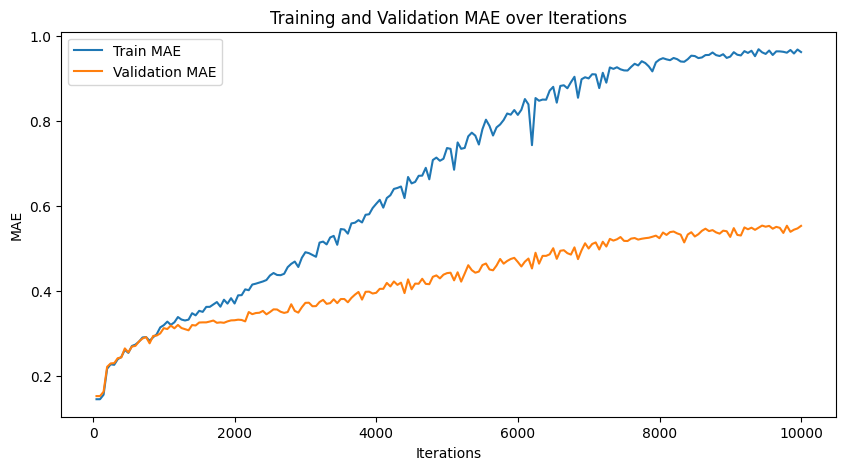

In [11]:
train_classifier(model2, train_one_hot_with_emb, val_one_hot_with_emb, 0.1, batch_size=100, num_epochs=100)

In [56]:
from utils import accuracy

temp = convert_to_one_hot(test_data, 
                          [(0, vocab_sector),
                           (1, vocab_type),
                           (2, vocab_state),
                           (3, vocab_level)])
temp = cat_emb(temp, test_data, 4)
test_one_hot_with_emb = MLPDataset(temp, [target.type(torch.LongTensor) for target in test_targets])

accuracy(model2, test_one_hot_with_emb)

0.5863192182410424